## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128] ,drp_ratio=0.2 ,l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                  kernel_regularizer=l2(l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                  kernel_regularizer=l2(l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
Dropout_EXP = 0.25
MOMENTUM = 0.95

In [17]:
results = {}
model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP,l2_ratio=1e-12)
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
___________________________

Epoch 42/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.3002 - acc: 0.5340 - val_loss: 1.3424 - val_acc: 0.5203
Epoch 43/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.3006 - acc: 0.5336 - val_loss: 1.3460 - val_acc: 0.5180
Epoch 44/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.3053 - acc: 0.5331 - val_loss: 1.3441 - val_acc: 0.5189
Epoch 45/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.2941 - acc: 0.5353 - val_loss: 1.3545 - val_acc: 0.5137
Epoch 46/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.2905 - acc: 0.5351 - val_loss: 1.3521 - val_acc: 0.5212
Epoch 47/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.2815 - acc: 0.5400 - val_loss: 1.3305 - val_acc: 0.5263
Epoch 48/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.2761 - acc: 0.5402 - val_loss: 1.3205 - val_acc: 0.5319
Epoch 49/50
50000/50

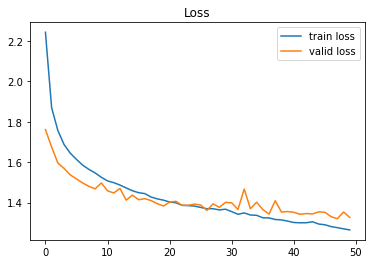

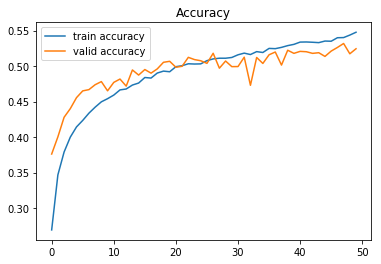

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()